In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 10 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 105008262.22it/s]


Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 84297629.66it/s]


Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29483273.21it/s]


Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16282503.22it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [02:05,  1.06s/it]


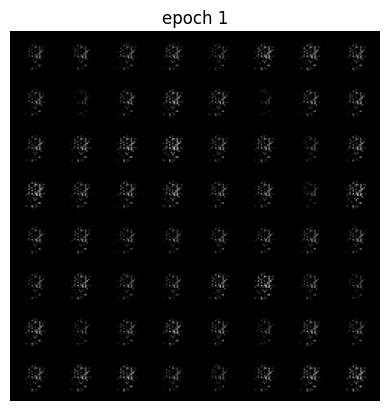

Epoch 1 of 100
Generator loss: 0.00512608, Discriminator loss: 0.00967127


118it [02:02,  1.04s/it]


Epoch 2 of 100
Generator loss: 0.00623964, Discriminator loss: 0.00317233


118it [02:02,  1.04s/it]


Epoch 3 of 100
Generator loss: 0.00498354, Discriminator loss: 0.00522505


118it [02:04,  1.05s/it]


Epoch 4 of 100
Generator loss: 0.00636660, Discriminator loss: 0.00497833


118it [02:01,  1.03s/it]


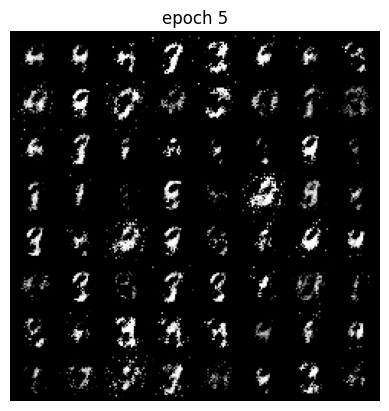

Epoch 5 of 100
Generator loss: 0.01208258, Discriminator loss: 0.00544321


118it [02:01,  1.03s/it]


Epoch 6 of 100
Generator loss: 0.00570167, Discriminator loss: 0.00526369


118it [02:03,  1.05s/it]


Epoch 7 of 100
Generator loss: 0.00774653, Discriminator loss: 0.00412921


118it [02:01,  1.03s/it]


Epoch 8 of 100
Generator loss: 0.00603184, Discriminator loss: 0.00736348


118it [02:03,  1.04s/it]


Epoch 9 of 100
Generator loss: 0.00999980, Discriminator loss: 0.00645169


118it [02:04,  1.05s/it]


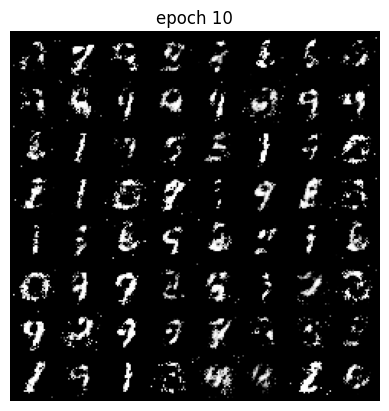

Epoch 10 of 100
Generator loss: 0.00762541, Discriminator loss: 0.00622156


118it [02:05,  1.07s/it]


Epoch 11 of 100
Generator loss: 0.00817772, Discriminator loss: 0.00696528


118it [02:04,  1.05s/it]


Epoch 12 of 100
Generator loss: 0.00918262, Discriminator loss: 0.00761824


118it [02:04,  1.06s/it]


Epoch 13 of 100
Generator loss: 0.00883061, Discriminator loss: 0.00738326


118it [02:02,  1.04s/it]


Epoch 14 of 100
Generator loss: 0.00739771, Discriminator loss: 0.00839706


118it [02:02,  1.04s/it]


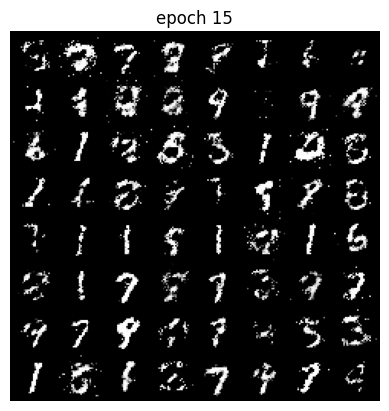

Epoch 15 of 100
Generator loss: 0.00688852, Discriminator loss: 0.00659754


118it [02:02,  1.04s/it]


Epoch 16 of 100
Generator loss: 0.00619137, Discriminator loss: 0.00927088


118it [02:02,  1.04s/it]


Epoch 17 of 100
Generator loss: 0.00709291, Discriminator loss: 0.00860661


118it [02:02,  1.04s/it]


Epoch 18 of 100
Generator loss: 0.00906356, Discriminator loss: 0.00793360


118it [02:01,  1.03s/it]


Epoch 19 of 100
Generator loss: 0.00789699, Discriminator loss: 0.00814708


118it [02:01,  1.03s/it]


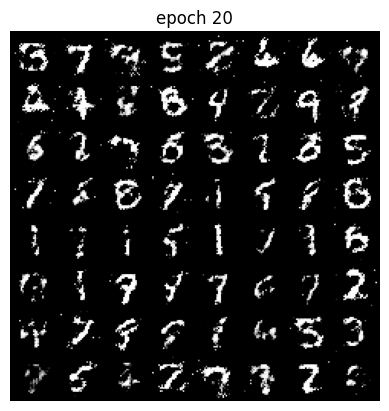

Epoch 20 of 100
Generator loss: 0.00840690, Discriminator loss: 0.00915536


118it [02:02,  1.04s/it]


Epoch 21 of 100
Generator loss: 0.00696837, Discriminator loss: 0.00808774


118it [02:02,  1.03s/it]


Epoch 22 of 100
Generator loss: 0.00735231, Discriminator loss: 0.00990065


118it [02:01,  1.03s/it]


Epoch 23 of 100
Generator loss: 0.00659252, Discriminator loss: 0.00959450


118it [02:02,  1.03s/it]


Epoch 24 of 100
Generator loss: 0.00664524, Discriminator loss: 0.00953055


118it [02:01,  1.03s/it]


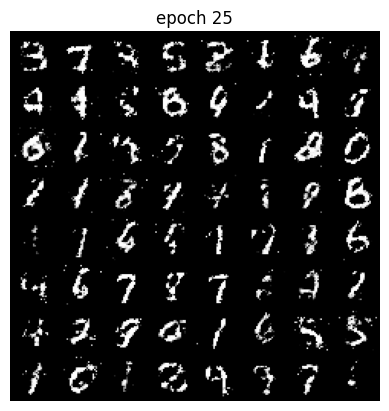

Epoch 25 of 100
Generator loss: 0.00670439, Discriminator loss: 0.01011289


118it [02:04,  1.06s/it]


Epoch 26 of 100
Generator loss: 0.00854164, Discriminator loss: 0.00773605


118it [02:03,  1.04s/it]


Epoch 27 of 100
Generator loss: 0.00816995, Discriminator loss: 0.00921429


118it [02:04,  1.06s/it]


Epoch 28 of 100
Generator loss: 0.00704958, Discriminator loss: 0.01020495


118it [02:04,  1.05s/it]


Epoch 29 of 100
Generator loss: 0.00624040, Discriminator loss: 0.01029668


118it [02:03,  1.05s/it]


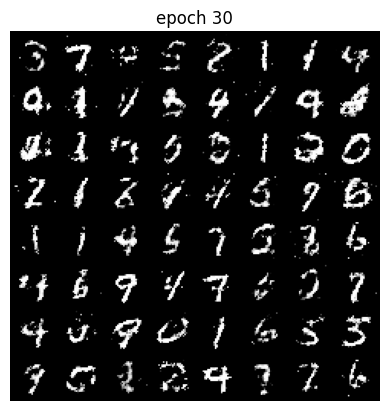

Epoch 30 of 100
Generator loss: 0.00747810, Discriminator loss: 0.00906064


118it [02:02,  1.04s/it]


Epoch 31 of 100
Generator loss: 0.00893445, Discriminator loss: 0.00969685


118it [02:04,  1.06s/it]


Epoch 32 of 100
Generator loss: 0.00665826, Discriminator loss: 0.00874569


118it [02:03,  1.05s/it]


Epoch 33 of 100
Generator loss: 0.00696629, Discriminator loss: 0.00910628


118it [02:04,  1.06s/it]


Epoch 34 of 100
Generator loss: 0.00691484, Discriminator loss: 0.01026099


118it [02:02,  1.04s/it]


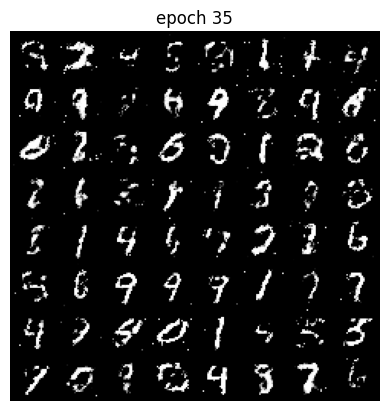

Epoch 35 of 100
Generator loss: 0.00674829, Discriminator loss: 0.01083085


118it [02:05,  1.06s/it]


Epoch 36 of 100
Generator loss: 0.00795264, Discriminator loss: 0.01024481


118it [02:03,  1.05s/it]


Epoch 37 of 100
Generator loss: 0.00630813, Discriminator loss: 0.01060566


118it [02:04,  1.05s/it]


Epoch 38 of 100
Generator loss: 0.00651317, Discriminator loss: 0.01057251


118it [02:03,  1.05s/it]


Epoch 39 of 100
Generator loss: 0.00768505, Discriminator loss: 0.00973973


118it [02:05,  1.07s/it]


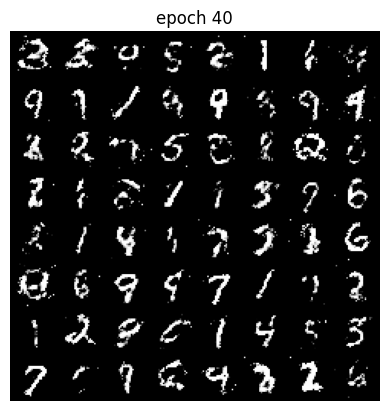

Epoch 40 of 100
Generator loss: 0.00710337, Discriminator loss: 0.00957961


118it [02:03,  1.05s/it]


Epoch 41 of 100
Generator loss: 0.00823925, Discriminator loss: 0.00943986


118it [02:04,  1.05s/it]


Epoch 42 of 100
Generator loss: 0.00662477, Discriminator loss: 0.00898640


118it [02:21,  1.20s/it]


Epoch 43 of 100
Generator loss: 0.00682755, Discriminator loss: 0.01052731


118it [02:20,  1.19s/it]


Epoch 44 of 100
Generator loss: 0.00731928, Discriminator loss: 0.01064168


118it [02:05,  1.06s/it]


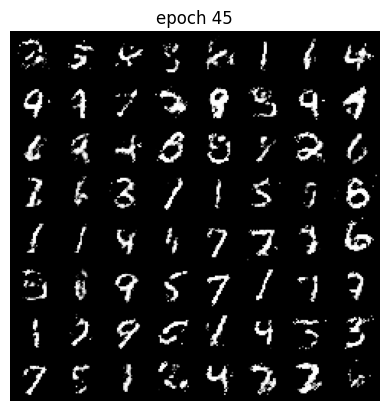

Epoch 45 of 100
Generator loss: 0.00710610, Discriminator loss: 0.01018657


118it [02:04,  1.06s/it]


Epoch 46 of 100
Generator loss: 0.00760203, Discriminator loss: 0.01070004


118it [02:04,  1.06s/it]


Epoch 47 of 100
Generator loss: 0.00700006, Discriminator loss: 0.01036739


118it [02:04,  1.05s/it]


Epoch 48 of 100
Generator loss: 0.00659094, Discriminator loss: 0.00956408


118it [02:06,  1.08s/it]


Epoch 49 of 100
Generator loss: 0.00646867, Discriminator loss: 0.01046712


118it [02:05,  1.06s/it]


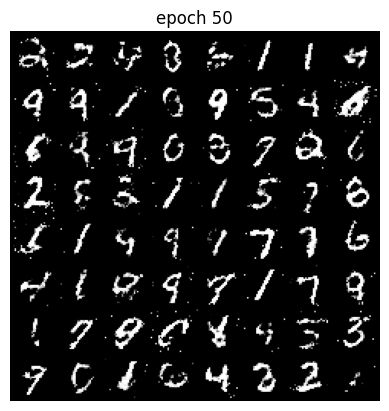

Epoch 50 of 100
Generator loss: 0.00619968, Discriminator loss: 0.01117707


118it [02:05,  1.06s/it]


Epoch 51 of 100
Generator loss: 0.00625910, Discriminator loss: 0.01101965


118it [02:04,  1.05s/it]


Epoch 52 of 100
Generator loss: 0.00682743, Discriminator loss: 0.01092093


118it [02:05,  1.06s/it]


Epoch 53 of 100
Generator loss: 0.00616185, Discriminator loss: 0.01178221


118it [02:02,  1.04s/it]


Epoch 54 of 100
Generator loss: 0.00714867, Discriminator loss: 0.01010117


118it [02:05,  1.06s/it]


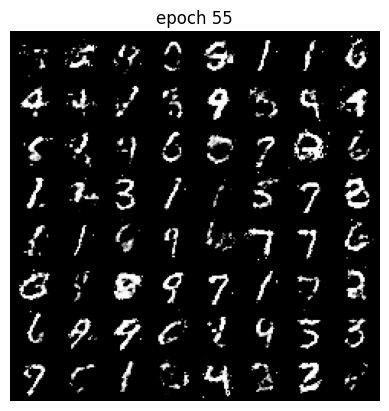

Epoch 55 of 100
Generator loss: 0.00723806, Discriminator loss: 0.01106903


118it [02:05,  1.06s/it]


Epoch 56 of 100
Generator loss: 0.00692821, Discriminator loss: 0.01049348


118it [02:04,  1.05s/it]


Epoch 57 of 100
Generator loss: 0.00618535, Discriminator loss: 0.01053933


118it [02:03,  1.05s/it]


Epoch 58 of 100
Generator loss: 0.00674613, Discriminator loss: 0.01084671


118it [02:02,  1.04s/it]


Epoch 59 of 100
Generator loss: 0.00607686, Discriminator loss: 0.01052792


118it [02:02,  1.04s/it]


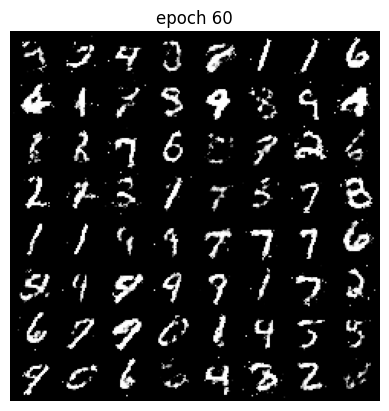

Epoch 60 of 100
Generator loss: 0.00658244, Discriminator loss: 0.01131075


118it [02:03,  1.05s/it]


Epoch 61 of 100
Generator loss: 0.00622243, Discriminator loss: 0.01052000


118it [02:02,  1.04s/it]


Epoch 62 of 100
Generator loss: 0.00643148, Discriminator loss: 0.01049193


118it [02:04,  1.05s/it]


Epoch 63 of 100
Generator loss: 0.00649299, Discriminator loss: 0.01128927


118it [02:03,  1.05s/it]


Epoch 64 of 100
Generator loss: 0.00697480, Discriminator loss: 0.01043691


118it [02:04,  1.06s/it]


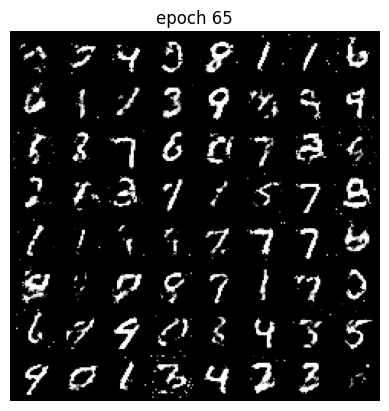

Epoch 65 of 100
Generator loss: 0.00677950, Discriminator loss: 0.01082874


118it [02:04,  1.05s/it]


Epoch 66 of 100
Generator loss: 0.00580363, Discriminator loss: 0.01117016


118it [02:07,  1.08s/it]


Epoch 67 of 100
Generator loss: 0.00699102, Discriminator loss: 0.01046695


118it [02:05,  1.06s/it]


Epoch 68 of 100
Generator loss: 0.00827975, Discriminator loss: 0.01041382


118it [02:05,  1.06s/it]


Epoch 69 of 100
Generator loss: 0.00615111, Discriminator loss: 0.00981456


118it [02:04,  1.06s/it]


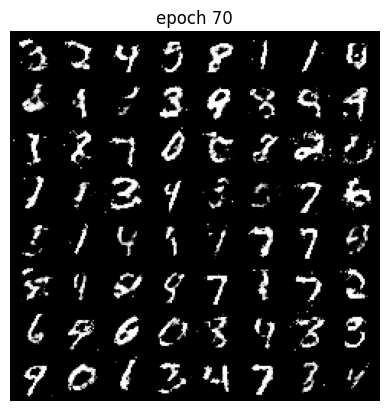

Epoch 70 of 100
Generator loss: 0.00737996, Discriminator loss: 0.01025371


118it [02:10,  1.10s/it]


Epoch 71 of 100
Generator loss: 0.00657048, Discriminator loss: 0.01107609


118it [02:15,  1.15s/it]


Epoch 72 of 100
Generator loss: 0.00680475, Discriminator loss: 0.01054247


118it [02:07,  1.08s/it]


Epoch 73 of 100
Generator loss: 0.00750830, Discriminator loss: 0.01021563


118it [02:06,  1.08s/it]


Epoch 74 of 100
Generator loss: 0.00716525, Discriminator loss: 0.01070618


118it [02:05,  1.07s/it]


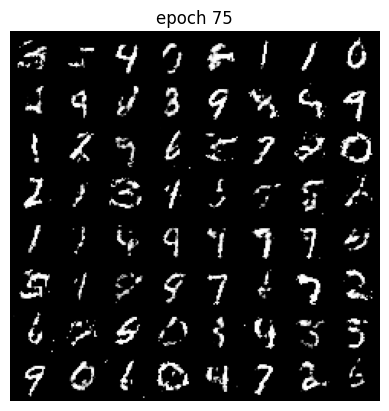

Epoch 75 of 100
Generator loss: 0.00622855, Discriminator loss: 0.01109087


118it [02:03,  1.05s/it]


Epoch 76 of 100
Generator loss: 0.00650866, Discriminator loss: 0.01060413


118it [02:05,  1.06s/it]


Epoch 77 of 100
Generator loss: 0.00601430, Discriminator loss: 0.01167313


118it [02:03,  1.05s/it]


Epoch 78 of 100
Generator loss: 0.00707422, Discriminator loss: 0.01079684


118it [02:05,  1.06s/it]


Epoch 79 of 100
Generator loss: 0.00678500, Discriminator loss: 0.01102639


118it [02:04,  1.06s/it]


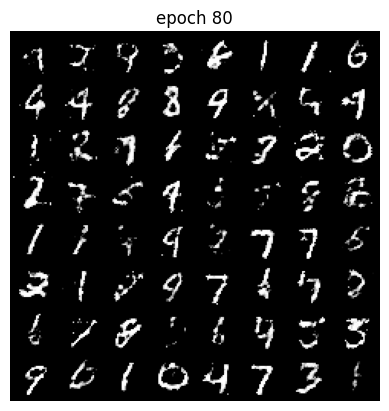

Epoch 80 of 100
Generator loss: 0.00658958, Discriminator loss: 0.01064072


118it [02:06,  1.07s/it]


Epoch 81 of 100
Generator loss: 0.00597883, Discriminator loss: 0.01101961


118it [02:08,  1.09s/it]


Epoch 82 of 100
Generator loss: 0.00658771, Discriminator loss: 0.01042263


118it [02:06,  1.08s/it]


Epoch 83 of 100
Generator loss: 0.00640006, Discriminator loss: 0.01047992


118it [02:05,  1.07s/it]


Epoch 84 of 100
Generator loss: 0.00649560, Discriminator loss: 0.00986239


118it [02:04,  1.05s/it]


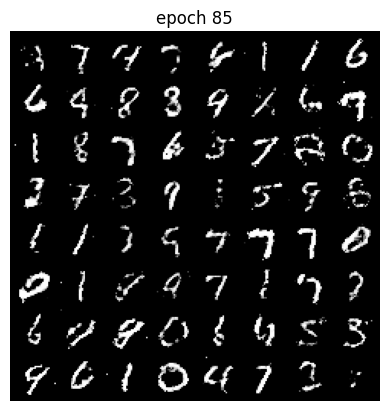

Epoch 85 of 100
Generator loss: 0.00615915, Discriminator loss: 0.01145925


118it [02:05,  1.06s/it]


Epoch 86 of 100
Generator loss: 0.00637137, Discriminator loss: 0.01130519


118it [02:04,  1.06s/it]


Epoch 87 of 100
Generator loss: 0.00682437, Discriminator loss: 0.01049414


118it [02:05,  1.06s/it]


Epoch 88 of 100
Generator loss: 0.00664923, Discriminator loss: 0.01116112


118it [02:05,  1.06s/it]


Epoch 89 of 100
Generator loss: 0.00652629, Discriminator loss: 0.01072359


118it [02:04,  1.06s/it]


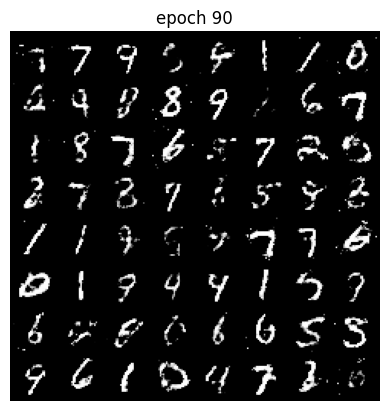

Epoch 90 of 100
Generator loss: 0.00657884, Discriminator loss: 0.01088100


118it [02:06,  1.07s/it]


Epoch 91 of 100
Generator loss: 0.00700535, Discriminator loss: 0.01121227


118it [02:04,  1.06s/it]


Epoch 92 of 100
Generator loss: 0.00710106, Discriminator loss: 0.01051719


118it [02:06,  1.07s/it]


Epoch 93 of 100
Generator loss: 0.00630254, Discriminator loss: 0.01113483


118it [02:07,  1.08s/it]


Epoch 94 of 100
Generator loss: 0.00691336, Discriminator loss: 0.01022829


118it [02:07,  1.08s/it]


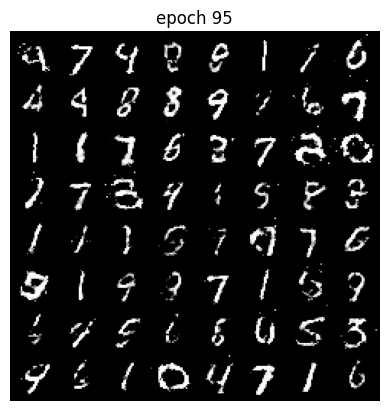

Epoch 95 of 100
Generator loss: 0.00738083, Discriminator loss: 0.00954352


118it [02:07,  1.08s/it]


Epoch 96 of 100
Generator loss: 0.00581326, Discriminator loss: 0.01054153


118it [02:07,  1.08s/it]


Epoch 97 of 100
Generator loss: 0.00607911, Discriminator loss: 0.01139040


118it [02:06,  1.07s/it]


Epoch 98 of 100
Generator loss: 0.00607457, Discriminator loss: 0.01128053


118it [02:07,  1.08s/it]


Epoch 99 of 100
Generator loss: 0.00696970, Discriminator loss: 0.01083886


118it [02:09,  1.09s/it]


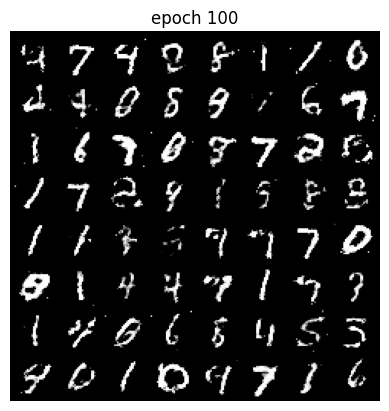

Epoch 100 of 100
Generator loss: 0.00609226, Discriminator loss: 0.01091821


In [14]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########

    # fake_labels = torch.ones_like(logits_fake, device=logits_fake.device)
    # loss = nn.functional.binary_cross_entropy_with_logits(logits_fake, fake_labels, reduction='mean')
    # print(true_label)
    loss = criterion(output, true_label)
    loss.backward()

    return loss
    ######################################

def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########

    # real_labels = torch.ones_like(logits_real, device=logits_real.device)
    # real_loss = nn.functional.binary_cross_entropy_with_logits(logits_real, real_labels, reduction='mean')
    loss = criterion(output, true_label)
    # loss.backward()

    # fake_labels = torch.zeros_like(logits_fake, device=logits_fake.device)
    # fake_loss = nn.functional.binary_cross_entropy_with_logits(logits_fake, fake_labels, reduction='mean')
    # loss = (real_loss + fake_loss)

    return loss
    ######################################

def discriminator_loss(true_output, real_labels, fake_output, fake_labels):
    ############ YOUR CODE HERE ##########

    # real_labels = torch.ones_like(logits_real, device=logits_real.device)
    # real_loss = nn.functional.binary_cross_entropy_with_logits(logits_real, real_labels, reduction='mean')
    real_loss = criterion(true_output, real_labels)

    # fake_labels = torch.zeros_like(logits_fake, device=logits_fake.device)
    fake_loss = criterion(fake_output, fake_labels)
    # real_loss.backward()
    # fake_loss.backward()
    loss = (real_loss + fake_loss)
    loss.backward()
    return loss
    ######################################


for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ##########


        ####### MY PREPROCESSING CODE #######


        # data[0] is 512 x 1 x 28 x 28, 512 black and white 28 x 28 images
        # data[1] is 512, 512 labels

        d_total_error = None
        # pre-process data
        all_images = data[0]
        all_labels = data[1]
        all_images = all_images.to(device)

        # normalized_image = (((all_images - torch.min(all_images)) / torch.max(all_images)) * 2) - 1

        # randomly sample 64 indices WITHOUT replacement
        real_image_sample_indices = np.random.choice(all_images.shape[0], sample_size, replace = False)
        minibatch_real_data = all_images[real_image_sample_indices, :, :, :]
        minibatch_real_labels = all_labels[real_image_sample_indices]

        # reshaped_minibatch_real_data = minibatch_real_data.reshape(minibatch_real_data.shape[0], -1)
        reshaped_minibatch_real_data = minibatch_real_data

        real_labels = label_real(sample_size)
        fake_labels = label_fake(sample_size)


        ####### END OF MY PREPROCESSING CODE #######

        ####### MY DISCRIMINATOR CODE #######

        for i in range(k):
          noise = create_noise(sample_size, nz)
          fake = generator(create_noise(sample_size, nz))
          fake_image_discriminator_output = discriminator(fake)
          real_image_discriminator_output = discriminator(reshaped_minibatch_real_data)

          loss_d = discriminator_loss(fake_image_discriminator_output, fake_labels, real_image_discriminator_output, real_labels)
          optim_d.zero_grad()
          # loss_d.backward()
          optim_d.step()


        ####### END OF MY DISCRIMINATOR CODE #######

        ####### MY GENERATOR CODE #######

        for i in range(k):
            noise = create_noise(sample_size, nz)
            fake = generator(noise)
            fake_image_discriminator_output = discriminator(fake)
            loss_g = generator_loss(fake_image_discriminator_output, real_labels)
            optim_g.zero_grad()
            # loss_g.backward()
            optim_g.step()

        ####### END OF MY GENERATOR CODE #######


        ######################################


    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # make the images as grid
    generated_img = make_grid(generated_img)

    # visualize generated images
    if (epoch + 1) % 5 == 0 or epoch == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [15]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [16]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

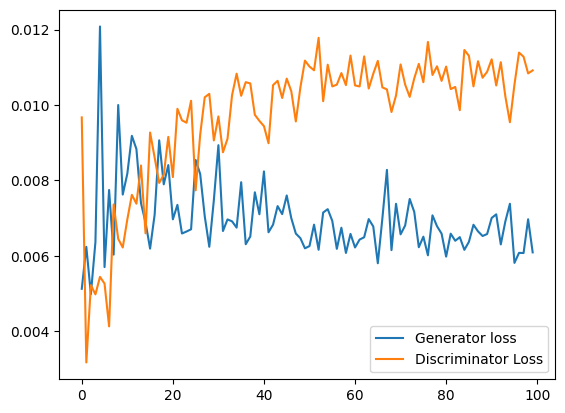

In [18]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot([val.detach().numpy() for val in losses_g], label='Generator loss')
plt.plot([val.detach().numpy() for val in losses_d], label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')